# Chest X-Ray Pathology Detection with Computer Vision

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import os
import cv2

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
np.set_printoptions(suppress=True)
plt.style.use("bmh")
config = {'figure.figsize': (16, 3),
          'axes.titlesize': 18,
          'axes.labelsize': 10,
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

In [4]:
IMAGE_DIR = "D:\Datasets\images_small"

# Objective

In this project, a chest X-ray classifier will be built to explore medical image diagnosis and to provide binary classification predictions for each of the 14 labeled pathologies.

# Dataset

The [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) will be used, which contains $108,948$ frontal-view X-ray images of $32,717$ unique patients. Each image contains labels identifying 14 different pathological conditions, which can in turn be used by physicians to diagnose 8 different diseases.  

Particularly, a subset of the data set was selected, consisting of the following files:

* `nih/train.csv`: 875 images to be used for training.
* `nih/test.csv`: 420 images to be used for testing. 

The papers [CheXNet](https://arxiv.org/abs/1711.05225) - [CheXpert](https://arxiv.org/pdf/1901.07031.pdf) - [ChexNeXt](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686) provide more details on the best performing methods and their performance on this data set.

# Data Preparation

In [5]:
train_df = pd.read_csv('utils/xray_train.csv')
test_df = pd.read_csv('utils/xray_test.csv')

In [6]:
print(f'Train size: {train_df.shape}, Test size: {test_df.shape}')
train_df.head()

Train size: (1000, 16), Test size: (420, 16)


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [7]:
labels = np.array(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'])

In [8]:
print(f'Null values: {train_df.isna().sum().sum()}')

Null values: 0


## Challenges in Medicine Problems

### Patient Overlap

In medicine problems, images from the same patient must not be in more than one data set: the train and test must be independent. For example, if a patient takes twice an x-ray wearing a necklace, and one of their x-rays is sampled as part of the train set and the other as part of test, when a deep learning model is trained, it correctly predicts normal for the x-ray in the test set. However, as deep learning models can unintentionally memorize train data or rare or unique train data aspects, the algorithm may memorize to output normal when it saw the patient with a necklace on. This would lead to an overly optimistic test set performance, where the model is thought to be better than it is. 

Patient overlap is an example of **data leakage**. To tackle this problem, a patient's X-rays must only occur in one of the sets, thus preventing the model from memorizing particular aspects of each patient and hence from helping it achieve a higher performance on the test set because it doesn't see the same patient.

In [9]:
print(f"Total patients: {train_df['PatientId'].count()}\nUnique patients: {train_df['PatientId'].value_counts().shape[0]}")

Total patients: 1000
Unique patients: 928


In [10]:
ids_train = train_df['PatientId'].values
ids_test = test_df['PatientId'].values

unique_ids_train = set(ids_train)
unique_ids_test = set(ids_test)
patient_overlap = list(unique_ids_train.intersection(unique_ids_test))

# Drop the overlapping rows from the testation set
test_df.drop(test_df[test_df['PatientId'].isin(patient_overlap)].index, inplace=True)

In [11]:
assert len(list(set(train_df['PatientId'].values).intersection(set(test_df['PatientId'].values)))) == 0

### Set Sampling

The challenge with sampling a test set is that, when randomly sampling a test set of hundreds of examples from the data set, no patients that have a disease might be selected, and the performance of the model cannot be tested on these positive cases. This is especially a problem with medical data with a small data set and with few examples of each disease. One way to tackle this is to sample a test set with at least X% (e.g. 50%) of examples of the minority class, the class for which there are fewer examples. This ensures that the study will have sufficient numbers to get a good estimate of the performance of the model both on non-disease and on disease examples. Finally, the remaining patients can be included in the train set. Because the test set has been artificially sampled to have a large fraction of mass examples, the train set will have a much smaller fraction of mass examples, but imbalanced train sets can be dealt with.

### Ground Truth and Consensus Voting

One major question when testing a model is how to determine the **ground truth**, the correct label for an example. On a chest X-ray, differentiating between some diseases might be complex, and experts may present inter-observer disagreement, i.e. discrepancies in their diagnosis. In such circumstances, the ground truth is determined by the **consensus voting method**: use a group of human experts to determine the ground truth. For example, three radiologists can look at a chest X-ray and each determines whether there is pneumonia present or not. If two out of the three say, yes, then the answer is yes. In general, the answer will be the majority vote of the three radiologists. Alternatively, three radiologists get into a room and discuss their interpretation until they reach a single decision, which can then be used as the ground truth.

## Data Visualization

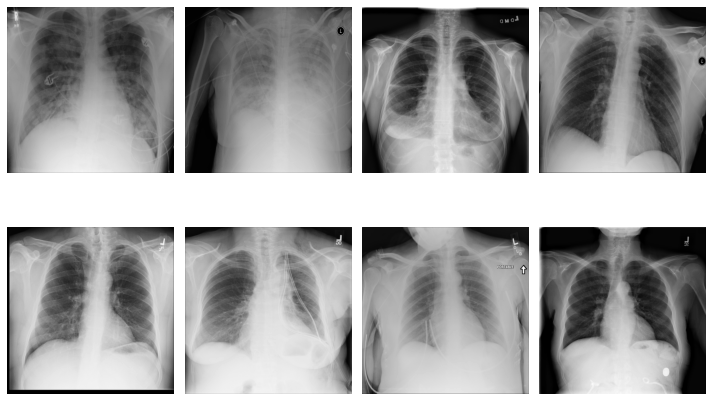

In [12]:
random_images = np.random.choice(train_df['Image'], 9)

fig, axes = plt.subplots(2, 4, figsize=(10, 7))
axes = axes.flatten()

for ax, image in zip(axes, random_images):
    img = plt.imread(os.path.join(IMAGE_DIR, image))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

One single color channel
Width: 1024 pixels
Height: 1024 pixels
Max pixel value: 0.98
Min pixel value: 0.00


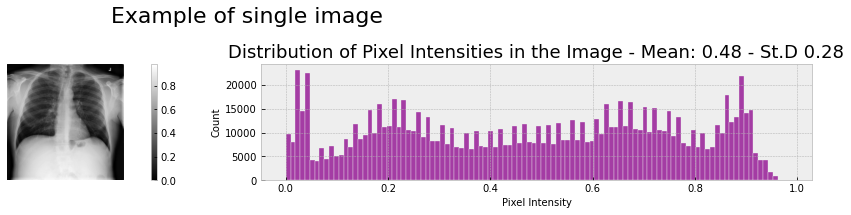

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

raw_image = plt.imread(os.path.join(IMAGE_DIR, train_df['Image'][0]))

print(f'One single color channel\nWidth: {raw_image.shape[0]} pixels\nHeight: {raw_image.shape[1]} pixels\nMax pixel value: {raw_image.max():.2f}\nMin pixel value: {raw_image.min():.2f}')

im = axes[0].imshow(raw_image, cmap='gray')
fig.colorbar(im, ax=axes[0])
axes[0].axis('off')

sns.histplot(raw_image.flatten(), color='darkmagenta', kde=False, ax=axes[1])
axes[1].set_title(f'Distribution of Pixel Intensities in the Image - Mean: {raw_image.mean():.2f} - St.D {raw_image.std():.2f}')
axes[1].set_xlabel('Pixel Intensity')

plt.suptitle('Example of single image', fontsize=22)
plt.tight_layout()
plt.show()

# Image Preprocessing

Once the data set is split into train and test, the model must be able to consume the images. After each epoch, the input will be shuffled, and the image size is set to 320px by 320px.

In [14]:
train_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True).flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        target_size=(320,320),
        class_mode="raw",
        batch_size=8,
        shuffle=True,
        seed=1,
)

Found 1000 validated image filenames.


**Example of standardized image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


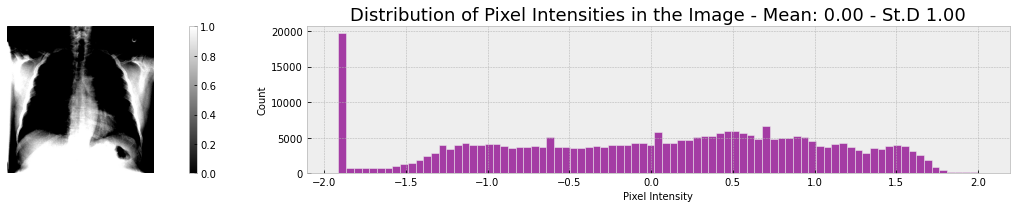

Width: 320 pixels
Height: 320 pixels
Max pixel value: 2.00
Min pixel value: -1.91


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 3))

generated_image, label = train_generator.__getitem__(0)
im = axes[0].imshow(generated_image[0], cmap='gray')
fig.colorbar(im, ax=axes[0])
axes[0].axis('off')

sns.histplot(generated_image[0].flatten(), color='darkmagenta', kde=False, ax=axes[1])
axes[1].set_title(f'Distribution of Pixel Intensities in the Image - Mean: {generated_image[0].mean():.2f} - St.D {generated_image[0].std():.2f}')
axes[1].set_xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

print(f'Width: {generated_image[0].shape[0]} pixels\nHeight: {generated_image[0].shape[1]} pixels\nMax pixel value: {generated_image[0].max():.2f}\nMin pixel value: {generated_image[0].min():.2f}')

A separate generator will be built for testing data, as the train generator normalizes each image per batch, and in a real-life scenario incoming (new) images are not processed a batch at a time, but one at a time. 

The incoming test data will be normalized using the statistics computed from the train set, which, although ideally these should be computed with the entire train set, this is very time consuming, and therefore a random sample of the data set will be taken and the sample mean and sample standard deviation will be used.

In [16]:
raw_train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col="Image",
    y_col=labels,
    target_size=(320, 320),
    class_mode="raw",
    batch_size=100,
    shuffle=True,
)

# Use sample to fit mean and std for test set generator
data_sample = raw_train_generator.next()[0]
image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
image_generator.fit(data_sample)

test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        target_size=(320,320),
        class_mode="raw",
        batch_size=8,
        shuffle=False,
        seed=1,
)

Found 1000 validated image filenames.
Found 420 validated image filenames.


# Class Imbalance Impact on Loss Function

If two dummy models were proposed, were Model 1 always outputs a 0.9 and Model 2 always outputs a 0.1. Consider a **Regular Loss Function** on two cases:

* If the data were perfectly balanced, Model 1 and Model 2 would have the same loss.
* If the data is imbalanced, Model 1 would have a smaller loss ($2.6187$) than Model 2 ($7.0131$), hence implying that Model 1 is better than Model 2.

If a regular cross-entropy loss function is used with a highly unbalanced dataset, the algorithm will be incentivized to prioritize the majority class, since it contributes more to the loss.

Therefore, for imbalanced data, a **Weighted Loss Function** should be used. Now, the same weighted loss will be obtained for both models, as both are "symmetric" along the midpoint of 0.5, i.e. a prediction of 0.9 is 0.1 away from the positive label of 1, and a prediction of 0.1 is 0.1 away from the negative label of 0. The equation is then given by:

$$ loss(x) = -w_p y log(\hat{y}) + -w_n (1 - y) log(1 - \hat{y})$$

where $x$ is the input vector, $y$ is the target vector, $\hat{y}$ is model prediction vector, and $w_p$ and $w_n$ are the weights for positive and negative labels, respectively, calculated as the fraction of negative labels, and the fraction of positive labels, respectively.

So, even though there is a class imbalance, the weighted loss accounts for this by giving more weight to the negative label than to the positive label.

For more than one class, e.g. pathologies, it is expected to calculate different weighted loss values for each category, as the model predictions and data will differ from one category to another.

In [17]:
class_percentages = train_df.sum().drop(['Image','PatientId']) / train_df.shape[0] * 100

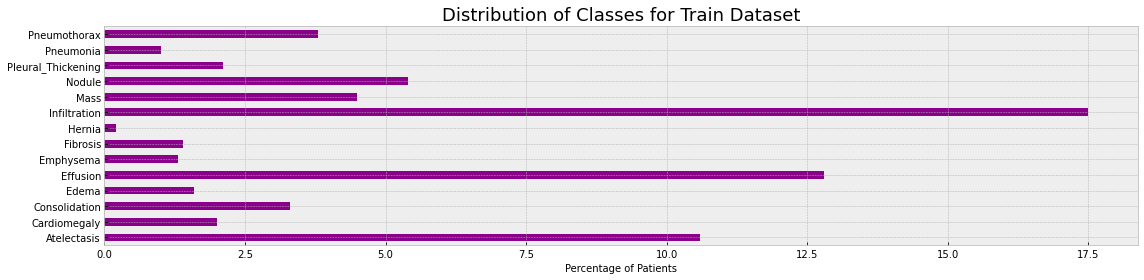

In [18]:
plt.figure(figsize=(16, 4))
class_percentages.plot.barh()
plt.title('Distribution of Classes for Train Dataset')
plt.xlabel('Percentage of Patients')
plt.ylabel('')
plt.tight_layout()
plt.show()

From the above plot it can be seen that that the prevalence of positive cases varies significantly across the different pathologies. These trends mirror the ones in the full data set as well). The Hernia pathology has the greatest imbalance, with a proportion of positive train cases of $0.2\%$, and even the Infiltration pathology, which has the least amount of imbalance, has only $17.5\%$ of the train cases labeled positive.

Ideally, the model would be trained using an evenly balanced data set, so that the positive and negative train cases would contribute equally to the loss.

In [29]:
freq_pos = np.sum(train_generator.labels, axis = 0) / len(train_generator.labels)
freq_neg = 1 - freq_pos

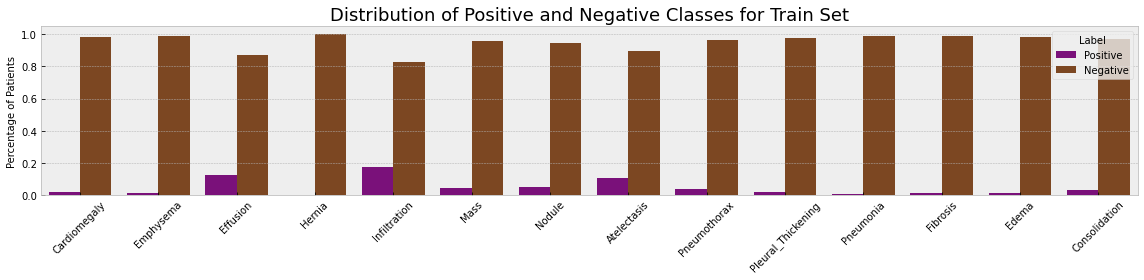

In [30]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.figure(figsize=(16, 4))
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Patients')
plt.xlabel('')
plt.title('Distribution of Positive and Negative Classes for Train Set')
plt.tight_layout()
plt.show()

As seen in the above plot, the contributions of positive cases is significantly lower than that of the negative ones, and they are desired to be equal. This can be done by multiplying each example from each class by a class-specific weight factor, $w_p$ and $w_n$, so that the overall contribution of each class is the same:

$$w_p \times freq_{p} = w_n \times freq_{n},$$

which can do simply by taking 

$$w_p = freq_{neg}$$
$$w_n = freq_{pos}$$

This way, the contribution of positive and negative labels are balanced.

In [31]:
w_p = freq_neg
w_n = freq_pos
pos_contribution = freq_pos * w_p 
neg_contribution = freq_neg * w_n

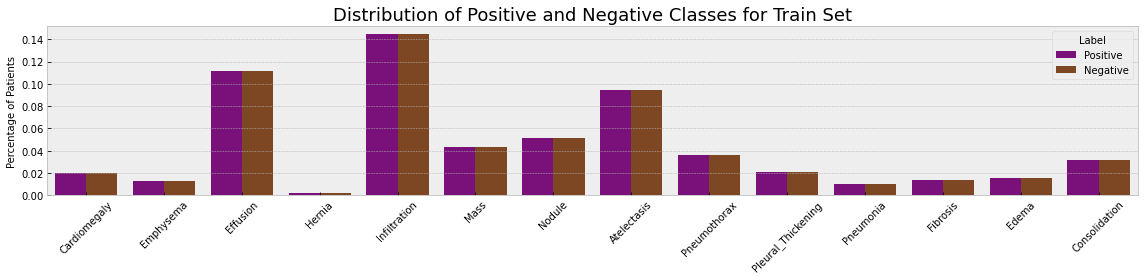

In [32]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)

plt.figure(figsize=(16, 4))
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Patients')
plt.xlabel('')
plt.title('Distribution of Positive and Negative Classes for Train Set')
plt.tight_layout()
plt.show()

As the above figure shows, weighting the positive and negative labels within each class would have the same aggregate contribution to the loss function.

For the multi-class loss, the resulting loss function for each class will be the following:

$$ loss(x) = \dfrac{1}{n} \sum -w_p y log(\hat{y} + \epsilon) + -w_n (1 - y) log(1 - \hat{y} + \epsilon)$$

$\epsilon = 10^{-7}$ is added to the predicted values to avoid a numerical error due to the log of $0$.

In [33]:
def get_weighted_loss(w_p, w_n, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):

        loss = 0.0

        for i in range(len(w_p)):
            loss += K.mean(-(w_p[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + w_n[i]* (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)))
        return loss
    
    return weighted_loss

# Model

Transfer learning will be used to retrain a DenseNet model for X-ray image classification. Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network. For a detailed explanation of Densenet, check the paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

A pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model will be used, to which the following layers will be added on top:

1. A GlobalAveragePooling2D layer to get the average of the last convolution layers from DenseNet121.
2. A Dense layer with sigmoid activation to get the prediction logits for each of our classes.

In [34]:
# Create the base pre-trained model
base_model = DenseNet121(weights='utils/densenet.hdf5', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x) # Add a global spatial average pooling layer
predictions = Dense(len(labels), activation="sigmoid")(x) # And a logistic layer

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(w_p, w_n))

Instructions for updating:
Colocations handled automatically by placer.


## Train

In [35]:
model.load_weights("utils/pretrained_model.h5")

## Predict

In [36]:
predicted_vals = model.predict(test_generator, steps=len(test_generator))

C:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Visualizing Learning with GradCAM 

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM), which are useful for understanding where the model is "looking" when classifying an image. 

GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, a heatmap is generated by computing gradients of the specific class scores we are interested in visualizing.

There are a lot of layers, but typically we'll only be extracting one of the last few. Remember that the last few layers usually have more abstract information.

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. However, it is still a useful tool for "debugging" the model and augmenting the prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

In this section, a [GradCAM's](https://arxiv.org/abs/1610.02391) technique will be used to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. This is done by extracting the gradients of each predicted class, flowing into the model's final convolutional layer.

In [37]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(np.array(Image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = Image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels, layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original", fontsize=12)
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}", fontsize=12)
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1
            
    plt.tight_layout()
    plt.show()

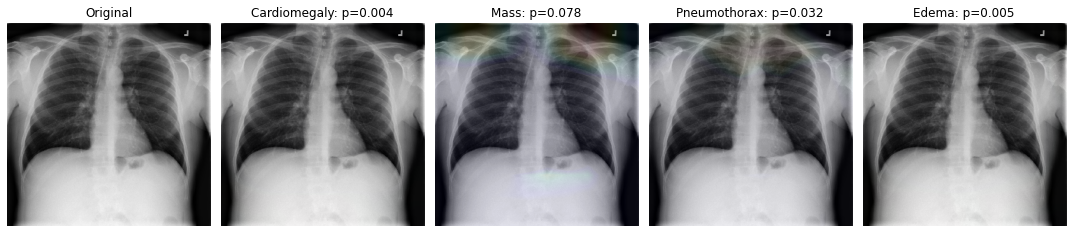

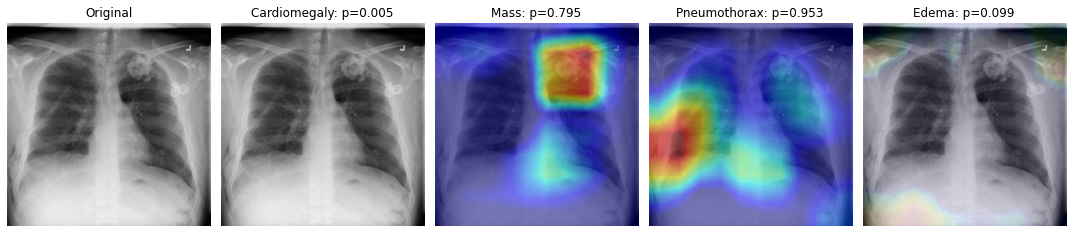

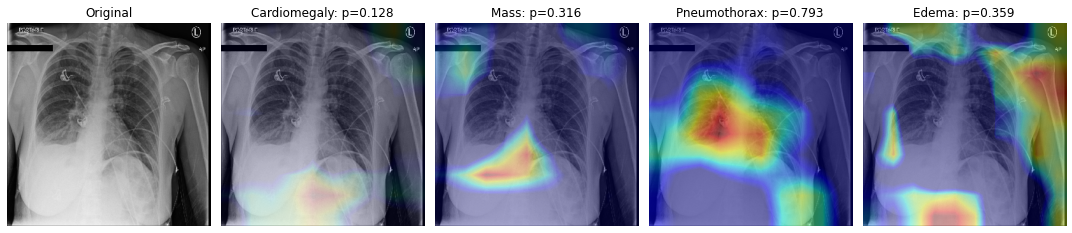

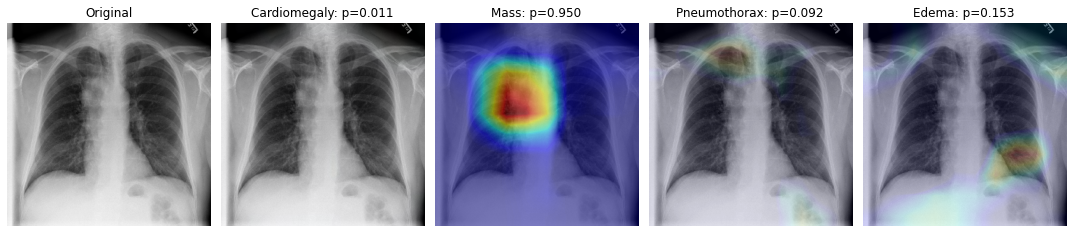

In [38]:
labels_to_show = ['Cardiomegaly', 'Edema', 'Mass', 'Pneumothorax']

images = ['00008270_015.png', '00011355_002.png', '00029855_001.png', '00005410_000.png']
for image in images:
    compute_gradcam(model, image, "D:/Datasets/images_small/", train_df, labels, labels_to_show)

## Evaluation

### Accuracy

It is not correct to evaluate the model's performance solely on the accuracy metric. For example, the model is not very accurate for detecting the Infiltration cases (accuracy of 0.657), but is pretty accurate for detecting Emphysema (accuracy of 0.889). A dummy model that simply predicts that any patient does not have Emphysema would be 97% accurate, but this model would be wrong 100% of the time if the patient actually had this condition, and would fail to do its purpose (diagnose a disease). More advanced model measures such as sensitivity and specificity evaluate how well the model predicts positives for patients with the condition and negatives for cases that actually do not have the condition.

### Prevalence

In a medical context, prevalence is the proportion of people in the population who have the disease (or condition, etc). In machine learning terms, it is the proportion of positive examples. The expression for prevalence is:

$$prevalence = \frac{1}{N} \sum_{i} y_i$$

where $y_i = 1$  when the example is 'positive' (has the disease).

Hernia has a prevalence 0.002, which is the rarest among the studied conditions in the data set.

### ROC Curve and AUROC

Briefly, a curve that is more to the left and the top has more area under it indicates that the model is performing better. In medical literature the AUCROC gives the probability that a randomly selected patient who experienced a condition had a higher risk score than a patient who had not experienced the event.

For more information on evaluation on the data set relate to [Rajpurkar, P., Irvin, J., Ball, R. L., Zhu, K., Yang, B., Mehta, H., ... & Lungren, M. P. (2018). Deep learning for chest radiograph diagnosis: A retrospective comparison of the CheXNeXt algorithm to practicing radiologists. PLoS medicine, 15(11), e1002686.](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686).

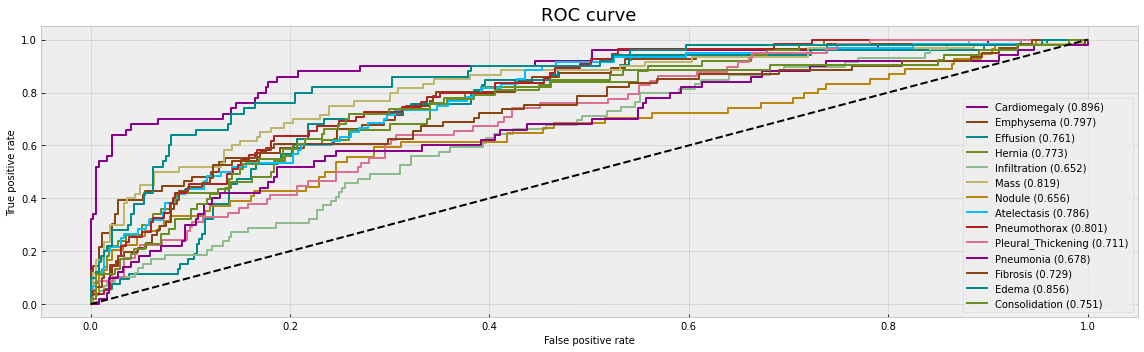

In [39]:
plt.figure(figsize=(16, 5))

for i, label in enumerate(labels):
    true = test_generator.labels[:, i]
    pred = predicted_vals[:, i]
    
    auc_roc = roc_auc_score(true, pred)    
    fpr_rf, tpr_rf, _ = roc_curve(true, pred)

    plt.plot(fpr_rf, tpr_rf, label=f'{label} ({str(round(auc_roc, 3))})')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.tight_layout()
plt.show()

# References

[Coursera - AI for Medical Diagnosis - Week 1 and Week 2](https://www.coursera.org/learn/ai-for-medical-diagnosis)